# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

Нам предстоит провести исследование данных, проверить на наличие аномалий и избавиться от них. Далее, нам необходимо протестировать несколько моделей, одной из которой будет LightGBM, и как минимум одна- не бустинг. Надо будет сравнить результаты, время обучения и скорость предсказания и выбрать оптимальную.

**Наш работа пройдет в 7 этапов:**
- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

Приступим к работе

 ## Произведем необходимые импорты

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install category_encoders

     |████████████████████████████████| 81 kB 2.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

import lightgbm as lgb

from catboost import CatBoostRegressor, cv, Pool


import category_encoders as ce


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Подготовка данных

### Загрузим данные

In [6]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Документация датасета

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType`— тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

**Не информативными являются признаки:**
- `LastSeen` - дата последней активности пользователя
- `DateCreated` — дата создания анкеты
- `DateCrawled` — дата скачивания анкеты из базы


**Остается под вопросом:**
- `PostalCode` - почтовый индекс владельца анкеты (пользователя), так как возможно можно будет отследить изменение цены по регионам.
- `NumberOfPictures` - количество фотографий автомобиля, инетересно понаблюдать как это вообще влияет. Возмодно владельцы, которым  нечего скрывать, выкладывают больше фотографий.

### Изучим данные

Выведем общую  информацию о датасете

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**признак NumberOfPictures не имеет каких-либо значений отличных от 0, значит, он не несет никакого практического смысла для нас, можем его удалить**

В данных присутствую пропуски, в признаках отвечающих за дату нужно изменить тип данных на дату. Посмотрим на типы данных повнимательнее

In [9]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

Скопируем изначальный датасет в запасную переменную

In [10]:
df_init = df.copy()

In [11]:
%%time

del df['LastSeen']


CPU times: user 18.4 ms, sys: 20 ms, total: 38.4 ms
Wall time: 37.4 ms


будем использовать конструкцию drop, так как она привычнее и можно удалить сразу несколько столбцов

In [12]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode'],
      dtype='object')

In [13]:
df = df.drop(['DateCrawled', 'DateCreated','NumberOfPictures'],axis=1)

In [14]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

Выделим int и object признаки

In [15]:
df.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [16]:
numeric_feats = ['Price', 'RegistrationYear','Power','Kilometer','RegistrationMonth','PostalCode']
obj_feats = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

#### Разберемся с пропусками

In [17]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
PostalCode               0
dtype: int64

In [18]:
display(df['VehicleType'].unique())
df['VehicleType'].value_counts()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [19]:
df.groupby(by=['Brand','PostalCode']).mean()

Price  RegistrationYear  Power  Kilometer  \
Brand      PostalCode                                               
alfa_romeo 1067        4800.0            2008.0  120.0    80000.0   
           1109        1500.0            2002.0  120.0   150000.0   
           1239        1000.0            2001.0  120.0   150000.0   
           1309        5400.0            2009.0  155.0   125000.0   
           1558         799.0            2005.0  146.0   150000.0   
...                       ...               ...    ...        ...   
volvo      99846        400.0            1998.0  115.0   150000.0   
           99848        800.0            1995.0   90.0   100000.0   
           99867       8900.0            2007.0  179.0   125000.0   
           99947       1860.0            1999.0  105.0   150000.0   
           99974       2500.0            1999.0  140.0   150000.0   

                       RegistrationMonth  
Brand      PostalCode                     
alfa_romeo 1067                     12.0  
           1109                      9.0  
           1239                      2.0  
           1309                      3.0  
           1558                      2.0  
...                                  ...  
volvo      99846                     5.0  
           99848                     9.0  
           99867                     6.0  
           99947                     9.0  
           99974                    12.0  

[92613 rows x 5 columns]

**избавимся от пропусков**


In [20]:
df_test = df.copy()

Посмотрим какой у нас баланс в каждом признаке

In [21]:
filled_objects = ['VehicleType','Gearbox','Model','FuelType','Repaired'] # объекты которые подлежат заполнению

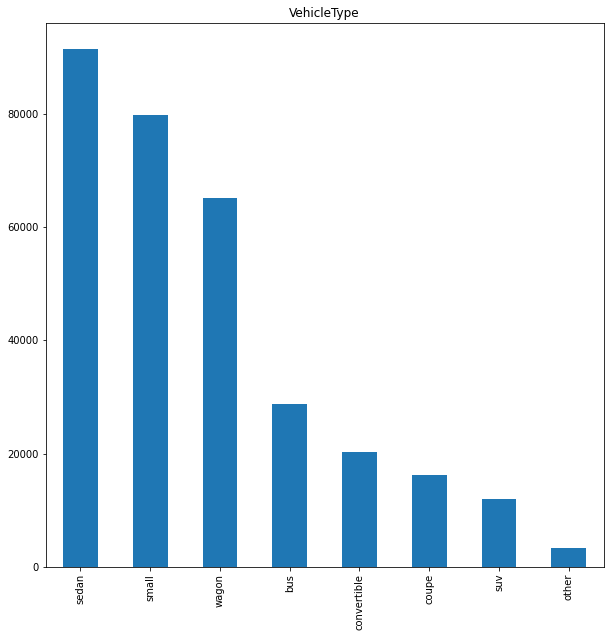

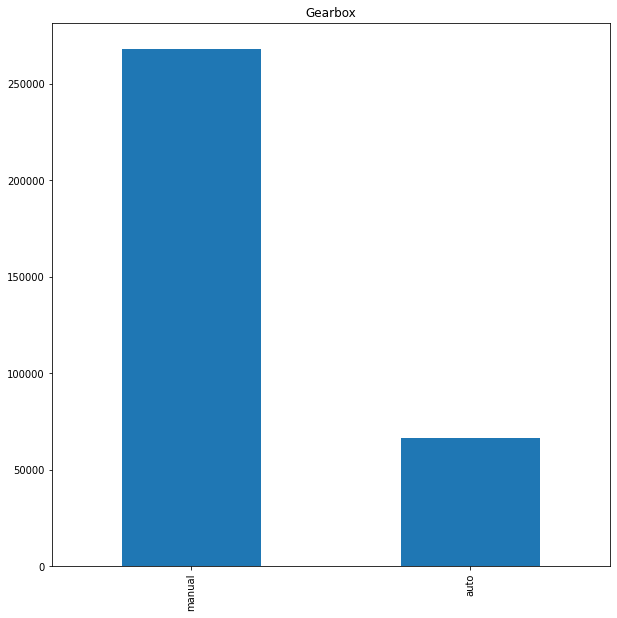

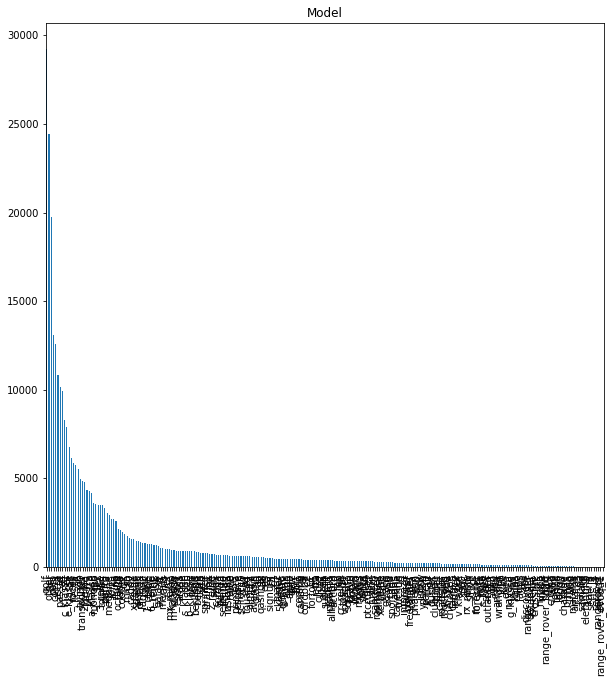

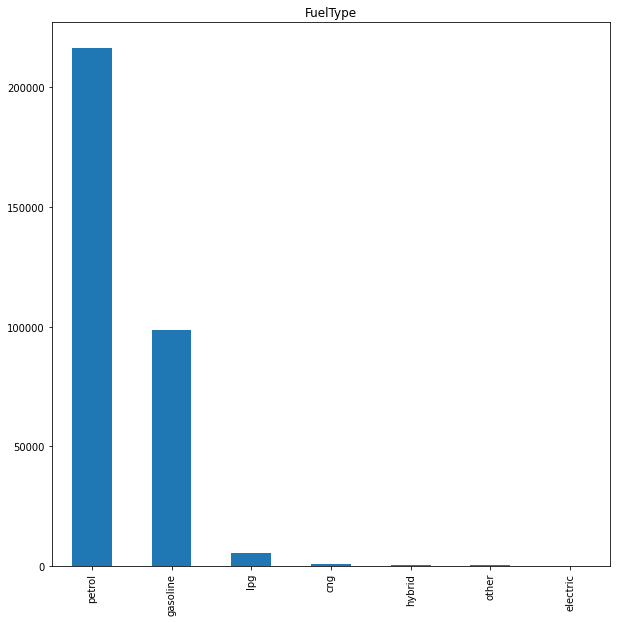

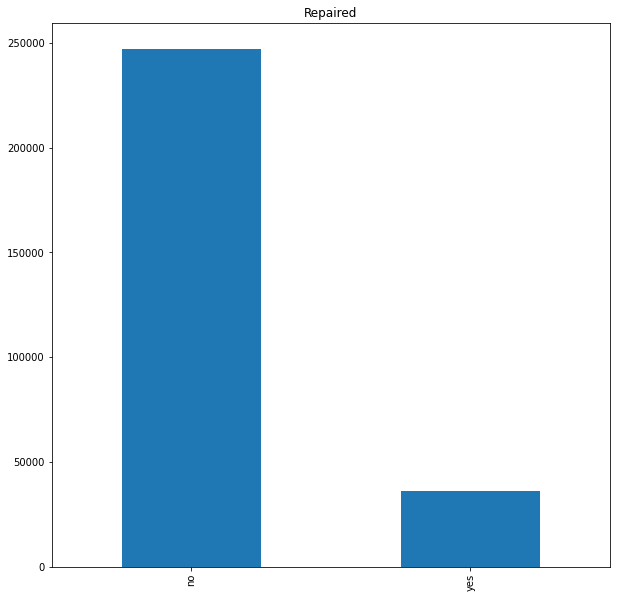

In [22]:
for feat in filled_objects:
    df[feat].value_counts().plot(kind='bar',figsize=(10,10), title=feat);
    plt.show()
# df_test[['VehicleType','Gearbox','Model','FuelType','Repaired']].value_counts().plot(kind='bar',figsize=(10,10));

In [23]:
df[['VehicleType','Gearbox','Model','FuelType','Repaired']] = (df
         .groupby(['Brand'])[['VehicleType','Gearbox','Model','FuelType','Repaired']]  # группируем авто по маркам
         .apply(lambda x: x.sort_values(by='VehicleType').fillna(method="bfill").fillna(method="ffill"))  # производим замены внутри групп марок
         .droplevel(0)   # избавляемся от мультииндекса
         .sort_index(ascending=True))[['VehicleType','Gearbox','Model','FuelType','Repaired']] # сортируем строки по индексу

In [24]:
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3374
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
Repaired                0
PostalCode              0
dtype: int64

In [25]:
df = df.dropna(subset=['Model'])
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

<Figure size 720x720 with 0 Axes>

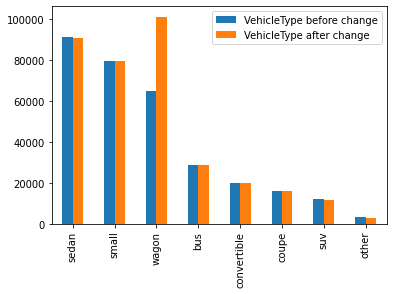

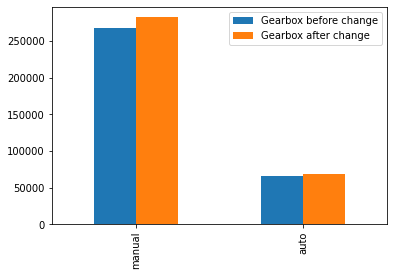

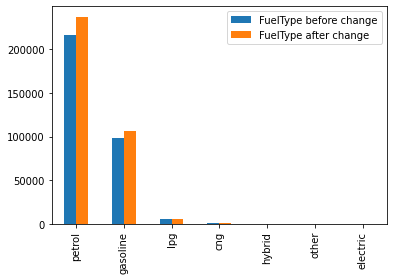

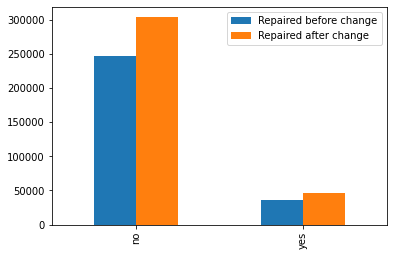

CPU times: user 794 ms, sys: 22.8 ms, total: 817 ms
Wall time: 832 ms


In [26]:
%%time
filled_objects = ['VehicleType','Gearbox','FuelType','Repaired'] # объекты которые подлежат заполнению

plt.figure(figsize=(10,10))
for feat in filled_objects:
    df_dinamic = pd.concat([df_test[feat].value_counts(),df[feat].value_counts()],names=['1','2'],axis=1)
    df_dinamic.columns=[str(feat)+' before change', str(feat)+' after change']
    df_dinamic.plot(kind='bar', );
    plt.show();

отлично, заменили пропуски, примерно сохранив баланс классов.

#### Проверим датасет на аномалии

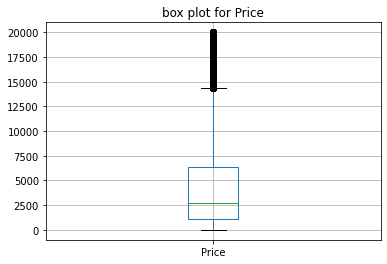

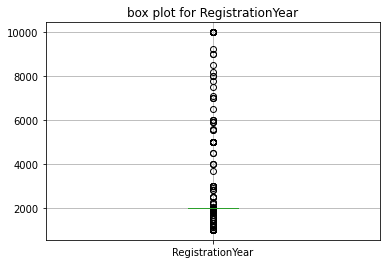

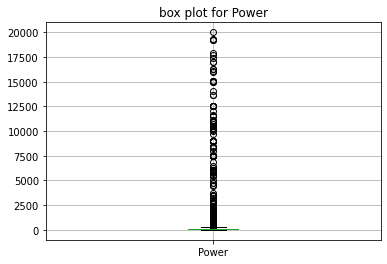

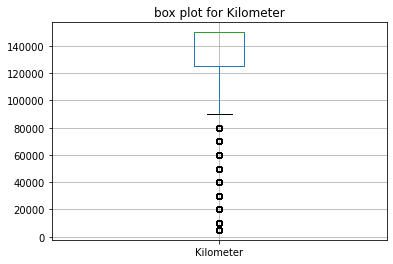

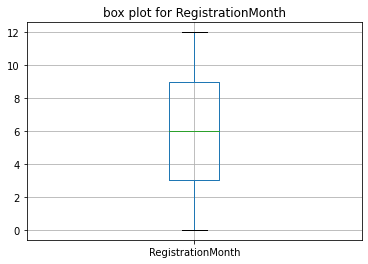

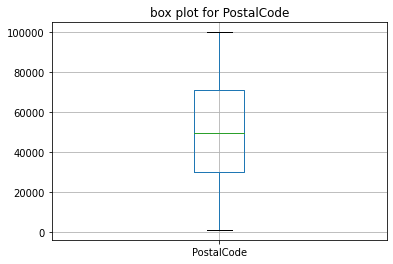

In [27]:
for feat in numeric_feats: 
    df[feat].plot(kind='box',grid=True, title='box plot for '+str(feat))
    plt.show()

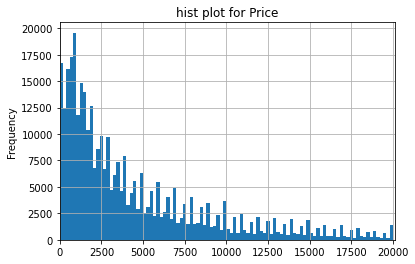

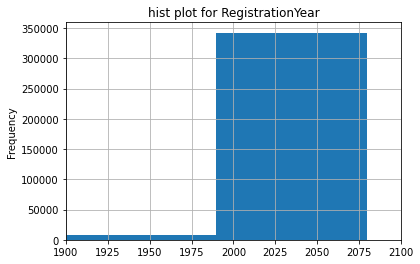

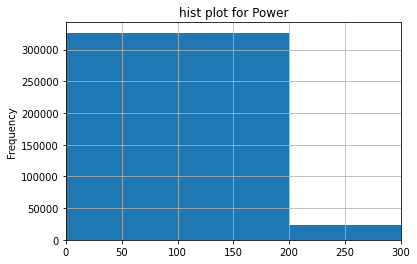

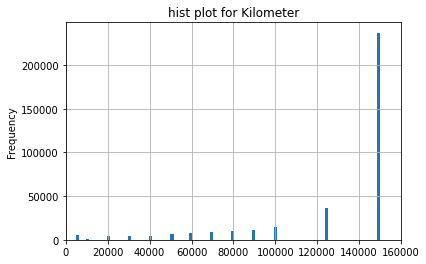

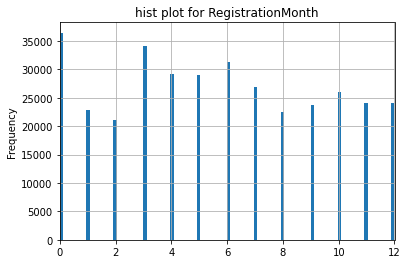

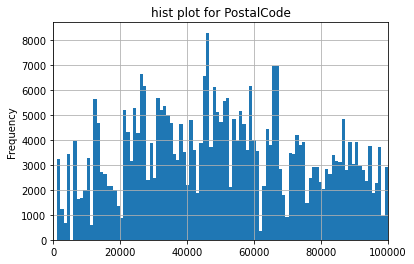

In [28]:
xl = [(0,20100), (1900,2100),(0,300),(0, 160000), (0,12),(0,100001)]
i = 0
for feat in numeric_feats: 
    df[feat].plot(kind='hist',grid=True, title='hist plot for '+str(feat), bins=100,xlim=xl[i])
    plt.show()
    i+=1
    

#### Исправляем аномалии

**Цена**

Цены оставим почти без изменений, но нужно только избавиться от совсем маленьких стоимостей.


In [29]:
df.loc[(df['Price']<100)&(df['Price']>=0)].shape

(12640, 12)

Избавимся от этих данных, потому что их не так много ,чтобы это как-то серьезно сказалось на обучении.

In [30]:
df = df.loc[df['Price']>100]
df.shape

(337341, 12)

**Год регистрации**

Проанализировав сайт auto.ru стало заметно, что до 1960 года, можно найти только очень редкие автомобили, и их всего 120 штук, поэтому посмотрим сколько всего позиций выходит за пределы наших рамок

In [31]:
df['RegistrationYear'].sort_values(ascending = False).unique()

array([9999, 9000, 8500, 8200, 7800, 7100, 7000, 6000, 5911, 5900, 5600,
       5555, 5000, 4500, 4000, 3700, 3000, 2900, 2800, 2500, 2290, 2200,
       2066, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010,
       2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999,
       1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988,
       1987, 1986, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977,
       1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966,
       1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958, 1957, 1956, 1955,
       1954, 1953, 1952, 1951, 1950, 1949, 1947, 1945, 1943, 1942, 1941,
       1940, 1938, 1937, 1936, 1935, 1934, 1933, 1932, 1931, 1930, 1929,
       1928, 1927, 1923, 1910, 1800, 1602, 1600, 1500, 1400, 1300, 1234,
       1111, 1039, 1001, 1000])

В данных с годом регистрации есть выбросы, видимо, что в машины продают в далекой-далекой галактике в Мос Эйсли. Если строчек с "неправильным" годом совсем мало, то удалим их, если относительно мнгого, то заменим на среднее значение по году регистрации

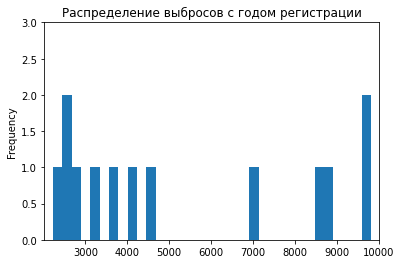

In [32]:
df['RegistrationYear'].value_counts().plot(kind = 'hist', bins = 100, xlim = (2020, 10000), title = 'Распределение выбросов с годом регистрации', ylim = (0, 3));
plt.show()

In [33]:
df.loc[df['RegistrationYear'] > 2019, 'RegistrationYear'].value_counts().sort_values()

2290     1
2800     1
5900     1
7800     1
2066     1
2900     1
8200     1
2200     1
9000     1
3700     1
5600     1
7100     1
8500     1
2500     2
5911     2
5555     2
4500     2
4000     3
6000     3
3000     3
7000     3
9999    11
5000    12
Name: RegistrationYear, dtype: int64

Да, таких значений совсем мало, поэтому можно удалить эти строчки

In [34]:
df = df.loc[df['RegistrationYear'] < 2020]
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,wagon,1993,manual,0,golf,150000,0,petrol,volkswagen,no,70435
1,18300,coupe,2011,manual,190,80,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [35]:
df.loc[(df['RegistrationYear']<=1960)|(df['RegistrationYear']>=2019)].shape

(303, 12)

In [36]:
df.shape

(337285, 12)

Уверен, что мы смело можем отбросим эти немногочисленные аномалии

In [37]:
df = df.loc[(df['RegistrationYear']>1960)&(df['RegistrationYear']<=2019)]
df.shape

(336995, 12)

In [38]:
df_init.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [39]:
df_init.loc[(df_init['RegistrationYear']<1960)|(df_init['RegistrationYear']>2020),['DateCrawled','RegistrationYear']].head(20)

,DateCrawled,RegistrationYear
15,2016-03-11 21:39:15,1910
622,2016-03-16 16:55:09,1111
1928,2016-03-25 15:58:21,1945
2273,2016-03-15 21:44:32,1925
3333,2016-03-15 21:36:20,1955
6629,2016-04-02 13:47:16,1910
6977,2016-03-24 08:37:22,1910
10183,2016-03-27 13:59:08,1910
12946,2016-03-29 18:39:40,5000
12992,2016-04-03 19:38:21,1954


**Количество сил**

Проанализировав сайт auto.ru, могу сказать, что зачастую автомобили имеют количество сил менее 350, но бывают исключения, бы на них постараемся закрыть глаза, потом учто это уже очень редко попадающиеся автомобили.

Проверим сколько таких автомобилей есть в наших данных.

In [40]:
df.loc[df['Power']>350].shape

(1086, 12)

Очень маленькое количество вылезает за эти пределы, поэтому безболезненно отбросим эти строки

<AxesSubplot:>

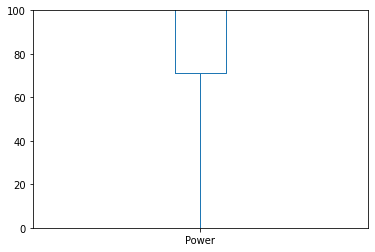

In [41]:
df['Power'].plot(kind='box', ylim=(0,100))

In [42]:
df.loc[df['Power']<1].shape

(33680, 12)

In [43]:
df.loc[df['Power']<50].shape

(38843, 12)

Реалистичная мощность автомобилей находится в пределах 50-350 л.с.

In [44]:
df = df.loc[(df['Power']<=350)&(df['Power']>=50)]
df.shape

(297066, 12)

**Пробег**

Пробег трогать не будет, потому что значения лежат в пределах нормы, поэтому оставим все как есть

**Месяц регистрации**

Месяц регистрации, на столбчатом графике видим, что значения месяца регистрации имеют значения от 0 до 12, очевидно, что нет 0го месяца. Поэтому заменим его на рандомное значение в пределах от 1 до 12 включительно. Потому что не совсем понятно как именно влияет месяц регистрации на стоимость. Но я слышал убеждение, что есть действительно такая закономерность, постараемся ее тоже проверить.

In [45]:
state = np.random.RandomState(12345)

In [46]:
df.loc[df['RegistrationMonth']==0, 'RegistrationMonth'] = np.random.randint(1,12)


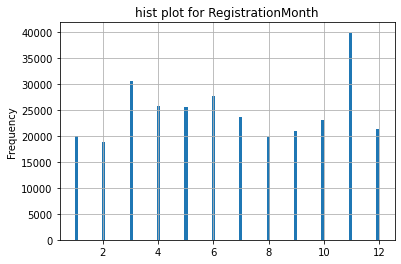

In [47]:
df['RegistrationMonth'].plot(kind='hist',grid=True, title='hist plot for RegistrationMonth', bins=100)
plt.show()

**Почтовый индекс**

С почтовым индексом все впорядке

### Проверим на явные дубликаты

In [48]:
df.duplicated().sum()

21073

In [49]:
df = df.drop_duplicates()

In [50]:
df.duplicated().sum()

0

In [51]:
df.shape

(275993, 12)

### Попробуем найти неявные дубликаты

In [52]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

In [53]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [54]:
df['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [55]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [56]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

Неявных дубликатов обнаружено не было!

### Итоги подготовки данных

Провели все необходимые проверки данных.

Посмотрели на количество пропусков. Устранили пропуски за счет замены их на значения, которые получили при разделение на группы по брендам, так как в брендах нет пропусков, не появилось никаких аномалий.

Проверили данные на аномалии, избавились от выбросов, удалив данные, так как их количество было мало.

Проверили на явные и неявные дубликаты, удалили явные дубликаты, неявных дубликатов в данных нет.

## Обучение моделей

Наша задача заключается в тестировании нескольких моделей.Этими моделями будут:
- [x] LinearRegression
- [x] RandomForestRegressor
- [x] LightGBM
- [x] CatBoost




### Разделим данные на выборки

Приходится делить выборки в отношении 6:4, потому что иначе при большей обучающей выборке умирает ядро):

In [57]:
features = df.drop('Price', axis=1)
target = df['Price']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)



print('Соотношение выборок: обучающая', features_train.shape[0],': валидационная',features_valid.shape[0],': тестовая',features_test.shape[0])

Соотношение выборок: обучающая 165595 : валидационная 55199 : тестовая 55199


Проведем прямое кодирование, бинарное кодирование для категориальных признаков.

In [58]:
features_train.dtypes

VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [59]:
import warnings

warnings.filterwarnings('ignore')

In [60]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

obj_feats = features_train.select_dtypes(include='object').columns.to_list()

encoder_ohe.fit(features_train[obj_feats])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [61]:
%%time

features_train_ohed = features_train.copy()
features_train_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohed[obj_feats])

features_train_ohed = features_train_ohed.drop(obj_feats, axis=1)

CPU times: user 36.3 s, sys: 1.94 s, total: 38.2 s
Wall time: 38.2 s


In [62]:
%%time
features_test_ohed = features_test.copy()
features_test_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohed[obj_feats])

features_test_ohed = features_test_ohed.drop(obj_feats, axis=1)

CPU times: user 9.91 s, sys: 612 ms, total: 10.5 s
Wall time: 10.8 s


In [63]:
%%time
features_valid_ohed = features_valid.copy()
features_valid_ohed[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_valid_ohed[obj_feats])

features_valid_ohed = features_valid_ohed.drop(obj_feats, axis=1)

CPU times: user 9.15 s, sys: 616 ms, total: 9.77 s
Wall time: 9.77 s


Провели прямое кодирование(One Hot Encoding) теперь приступим к обучению

In [64]:
ce_encoder = ce.BinaryEncoder()
features_train_encoded = ce_encoder.fit_transform(features_train)
features_valid_encoded = ce_encoder.transform(features_valid)
features_train_encoded.head()

,VehicleType_0,VehicleType_1,VehicleType_2,VehicleType_3,RegistrationYear,Gearbox_0,Gearbox_1,Power,Model_0,Model_1,...,FuelType_2,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Repaired_0,Repaired_1,PostalCode
309627,0,0,0,1,1998,0,1,116,0,0,...,1,0,0,0,0,0,1,0,1,2785
82360,0,0,1,0,2012,1,0,184,0,0,...,0,0,0,0,0,1,0,1,0,61476
223800,0,0,1,1,2009,1,0,71,0,0,...,1,0,0,0,0,1,1,1,0,21465
45399,0,0,1,1,2012,0,1,105,0,0,...,0,0,0,0,1,0,0,1,0,7745
196062,0,1,0,0,2003,0,1,116,0,0,...,1,0,0,0,1,0,1,1,0,84079


In [65]:
features_test_encoded = ce_encoder.transform(features_test)

### Линейная регрессия

In [66]:
numeric = numeric_feats[1:]
numeric

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

#### Масштабируем данные для линейной регрессии

In [67]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train_scaled_ohed = features_train_ohed.copy()
features_test_scaled_ohed = features_test_ohed.copy()

# Создадим Scaled и  Ohed для Train выборки
features_train_scaled_ohed[numeric] = scaler.transform(features_train[numeric])

features_test_scaled_ohed[numeric]  = scaler.transform(features_test[numeric])

In [68]:
# Создадим Scaled и Ohed выборку для Valid и для Test
features_valid_scaled_ohed = features_valid_ohed.copy()
features_valid_scaled_ohed[numeric] = scaler.transform(features_valid[numeric])

# Test
features_test_scaled_ohed = features_test_ohed.copy()
features_test_scaled_ohed[numeric] = scaler.transform(features_test[numeric])

In [69]:
features_train_scaled_ohed.columns

Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'PostalCode', 'x0_bus', 'x0_convertible', 'x0_coupe', 'x0_other',
       'x0_sedan',
       ...
       'x4_skoda', 'x4_smart', 'x4_subaru', 'x4_suzuki', 'x4_toyota',
       'x4_trabant', 'x4_volkswagen', 'x4_volvo', 'x5_no', 'x5_yes'],
      dtype='object', length=310)

####  Приступим к обучению регрессии

In [70]:
%%time
model_l = LinearRegression()

predictions_cv_lin = model_l.fit(features_train_scaled_ohed, target_train)

CPU times: user 10.9 s, sys: 3.1 s, total: 14 s
Wall time: 14 s


In [71]:
%%time
predictions_lin_valid = model_l.predict(features_valid_scaled_ohed)

CPU times: user 111 ms, sys: 100 ms, total: 211 ms
Wall time: 198 ms


In [72]:
rmse_cv_lin = mean_squared_error(target_valid, predictions_lin_valid) ** 0.5
print('RMSE Линейной регрессии равно:', rmse_cv_lin)

RMSE Линейной регрессии равно: 107118733741.69032


Очень плохой результат показала линейная регрессия, перейдем к случайному лесу

In [73]:
time_fit_lin = 4.18 # секунд
time_pred_lin = 0.445
rmse_valid_lin = 2615.2

### Случайный лес

In [74]:
%%time
best_depth = 0


best_est = 0

rmse_f_best = 1e300

depthes = [None]+[i for i in range(2,7)]
for depth in tqdm(depthes):
    for est in range(10,121, 25):
        
        model_f = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        
        #predictions_cv_forest = cross_val_predict(model_f, features_train_encoded, target_train)
        #predictions_forest = model_f.fit(features_train_scaled_ohed, target_train)
        #predictions_f = model_f.predict(features_valid_scaled_ohed)
        model_f.fit(features_train_encoded, target_train)
        
        predictions_f = model_f.predict(features_valid_encoded)
        rmse = mean_squared_error(target_valid, predictions_f)
        rmse = mean_squared_error(target_valid, predictions_f)
        if rmse < rmse_f_best:
            best_depth = depth
            best_est = est 
            rmse_f_best = rmse
        

100%|██████████| 6/6 [10:15<00:00, 102.53s/it]

CPU times: user 10min 11s, sys: 1.88 s, total: 10min 13s
Wall time: 10min 15s


При обучении модели случайно забыл выделить квадрат, поэтому сделаю ниже)

In [75]:
rmse_f_best = rmse_f_best ** 0.5

In [76]:
print('Лучший rmse случайного леса равен:', rmse_f_best)
print('Лучшая глубина леса', best_depth, 'лучшее количество деревьев', best_est)

Лучший rmse случайного леса равен: 1635.9565572840772
Лучшая глубина леса None лучшее количество деревьев 110


Лес показал себя намного лучше, чем линейная регрессия!

**Теперь обучим модель на обучающей выборке и протестируем на валидационной**

In [77]:
model_f = RandomForestRegressor(n_estimators=110, max_depth=None, random_state=12345)

In [78]:
%%time
model_f.fit(features_train_encoded, target_train)

CPU times: user 1min 45s, sys: 826 ms, total: 1min 45s
Wall time: 1min 46s


RandomForestRegressor(n_estimators=110, random_state=12345)

In [79]:
%%time
predictions_f = model_f.predict(features_valid_encoded)

CPU times: user 3.1 s, sys: 0 ns, total: 3.1 s
Wall time: 3.1 s


Посмотрим на результаты

In [80]:
rmse_forest = mean_squared_error(predictions_f,target_valid)**0.5
print('RMSE случайного леса равно:',rmse_forest)

RMSE случайного леса равно: 1635.9565572840772


In [81]:
time_fit_f = 1.44
time_pred_f = 2.8
rmse_forest = 1631













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































Результат уже гораздо лучше, чем у линейной регрессии, но все равно результат нас такой не устраивает.

### LightGBM

#### Этап с кросвалидацией можем пропустить, так как для задания он не нужен

In [82]:
#features_train.head()

In [83]:
#train_dataset = lgb.Dataset(features_train_ohed, target_train, feature_name=features_train_ohed.columns.to_list())
#test_dataset = lgb.Dataset(features_test_ohed, target_test, feature_name=features_test_ohed.columns.to_list())

In [84]:
#%%time
# booster = lgb.train({"objective": "regression"},
#                     train_set=train_dataset, valid_sets=(test_dataset,),
#                     num_boost_round=10)

#  #folds=sp,
#cv_res = lgb.cv({"objective": "regression"}, train_dataset, 400, shuffle=False, seed = None,
#            callbacks=[lgb.early_stopping(stopping_rounds=25, first_metric_only=True)],
#            return_cvbooster=True)


In [85]:
 #predictions_lgb = booster.predict(features_test_ohed)
 #cv_res

In [86]:
#%%time
#predictions_cv_lgb = cv_res['cvbooster'].predict(features_train_ohed)


In [87]:
#len(predictions_cv_lgb[0])

In [88]:
#target_train

#### LightGBM обучение и предсказание

In [89]:
train_dataset = lgb.Dataset(features_train_encoded, target_train, feature_name=features_train_encoded.columns.to_list())
valid_dataset = lgb.Dataset(features_valid_encoded, target_valid, feature_name=features_valid_encoded.columns.to_list())
test_dataset = lgb.Dataset(features_test_encoded, target_test, feature_name=features_test_encoded.columns.to_list())

In [90]:
%%time
model_lgb = lgb.train({"objective": "regression"},
                    train_set=train_dataset, valid_sets=(valid_dataset,),
                    num_boost_round=400)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.606885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 165595, number of used features: 30
[LightGBM] [Info] Start training from score 4814.338229
[1]	valid_0's l2: 1.78518e+07
[2]	valid_0's l2: 1.55152e+07
[3]	valid_0's l2: 1.35917e+07
[4]	valid_0's l2: 1.20158e+07
[5]	valid_0's l2: 1.0692e+07
[6]	valid_0's l2: 9.61241e+06
[7]	valid_0's l2: 8.69916e+06
[8]	valid_0's l2: 7.96204e+06
[9]	valid_0's l2: 7.28806e+06
[10]	valid_0's l2: 6.73411e+06
[11]	valid_0's l2: 6.28181e+06
[12]	valid_0's l2: 5.90661e+06
[13]	valid_0's l2: 5.5765e+06
[14]	valid_0's l2: 5.29756e+06
[15]	valid_0's l2: 5.07066e+06
[16]	valid_0's l2: 4.85311e+06
[17]	valid_0's l2: 4.6734e+06
[18]	valid_0's l2: 4.50864e+06
[19]	valid_0's l2: 4.36334e+06
[20]	valid_

In [91]:
%%time
predictions_valid_lgb = model_lgb.predict(features_valid_encoded)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.3 s


In [92]:
rmse_lgb = mean_squared_error(target_valid, predictions_valid_lgb)**0.5

print('rmse ', rmse_lgb)

rmse  1615.4997661247376


In [93]:
time_fit_lgb = 12
time_pred_lgb = 1.1
rmse_lgb = 1618

Отличный результат показал lightgbm, rmse равно 1624

### Catboost

#### Кросс-валидация
Будем считать, что кроссвалидация была проделана для ознакомления с библиоткеой

Используем катбуст регрессор, установим количество итераций 100, просто для тестирования.

In [94]:
model_cat = CatBoostRegressor(iterations=100)

In [95]:
cat_features = features_train.columns.to_list()

In [96]:
 #model_cat.cv(features_train, features)

In [97]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 300,
    'random_seed': 12345,
    'learning_rate': 0.5
}

cv_data = cv(
    params=params,
    pool=Pool(features_train, label=target_train, cat_features=cat_features),
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=12345,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 1717.383931
bestIteration = 297

Training on fold [1/5]



bestTest = 1659.830583
bestIteration = 286

Training on fold [2/5]



bestTest = 1644.495151
bestIteration = 293

Training on fold [3/5]



bestTest = 1618.395532
bestIteration = 298

Training on fold [4/5]



bestTest = 1616.898536
bestIteration = 299

CPU times: user 5min 29s, sys: 5.42 s, total: 5min 35s
Wall time: 5min 44s


#### CatBoost без кросс-валидации

In [98]:
features_train.dtypes

VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
PostalCode            int64
dtype: object

In [99]:
%%time
model_cat = CatBoostRegressor(iterations=400 , depth=5, learning_rate= 0.2)


cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=40, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4021.1341741	total: 147ms	remaining: 58.8s
40:	learn: 1796.2031147	total: 4.18s	remaining: 36.6s
80:	learn: 1716.3327421	total: 8.22s	remaining: 32.4s
120:	learn: 1671.6230553	total: 12.1s	remaining: 27.9s
160:	learn: 1646.3561550	total: 15.9s	remaining: 23.5s
200:	learn: 1629.3005439	total: 19.7s	remaining: 19.5s
240:	learn: 1614.4942800	total: 23.6s	remaining: 15.6s
280:	learn: 1602.7527189	total: 27.3s	remaining: 11.6s
320:	learn: 1592.1134927	total: 31s	remaining: 7.62s
360:	learn: 1582.9237762	total: 34.8s	remaining: 3.76s
399:	learn: 1574.3740923	total: 38.7s	remaining: 0us
CPU times: user 39.2 s, sys: 146 ms, total: 39.3 s
Wall time: 40.5 s


In [100]:
%%time
predictions_cat = model_cat.predict(features_valid)

CPU times: user 165 ms, sys: 4.02 ms, total: 169 ms
Wall time: 166 ms


In [101]:
rmse_cat = mean_squared_error(target_valid, predictions_cat)**0.5
print('Значение RMSE для модели catboost равно', rmse_cat)

Значение RMSE для модели catboost равно 1637.032777696201


Отлично, мы получили метрику rmse равную 1631.

In [102]:

time_fit_cat = 27
time_pred_cat = 0.281
rmse_cat = 1631

### Итоги обучения

Провели обучение 4 моделей обучения, два бустинга : lightgbm и catboost и два не бустинга: линейная регрессия и случайный лес. В следующем пункте сравним модели по времени обучения, времени предсказания и качеству предсказания

## Анализ моделей

Перейдем к анализу моделей, мы в нашем исследовании использовали 4 модели, LightGBM, CatBoost, LinearRegression, RandomForestRegressor. Перейдем к сравнению по времени обучения, по времени предсказания, по качетсву предсказания.

In [103]:
print('Линейная регрессия')
print('Время обучения',time_fit_lin,'секунд. Время предсказания',time_pred_lin,'секунд. Качество модели', rmse_valid_lin)
print()
print('Случайный лес')
print('Время обучения',time_fit_f ,'секунды. Время предсказания',time_pred_f,'секунд. Качество модели', rmse_forest)
print()
print('LightGBM')
print('Время обучения',time_fit_lgb ,'секунд. Время предсказания',time_pred_lgb,'секунд. Качество модели', rmse_lgb)
print()
print('CatBoost')
print('Время обучения',time_fit_cat ,'секунд. Время предсказания',time_pred_cat,'секунд. Качество модели', rmse_cat)

Линейная регрессия
Время обучения 4.18 секунд. Время предсказания 0.445 секунд. Качество модели 2615.2

Случайный лес
Время обучения 1.44 секунды. Время предсказания 2.8 секунд. Качество модели 1631

LightGBM
Время обучения 12 секунд. Время предсказания 1.1 секунд. Качество модели 1618

CatBoost
Время обучения 27 секунд. Время предсказания 0.281 секунд. Качество модели 1631


**Итоги сравнения**

CatBoost и LightGBM показали себя на достойном уровне, у них хорошее качетсво и достаточно быстрое обучение. Но у CatBoost есть одно огромное преимущество, для нескольких десятков тысяч строк признаков модель делает предсказания менее чем за 0.3 секунды. Я считаю, что в данном случае при остальных равных показателях, этот является самым важным.

### Итоговое обучение CatBoost и проверка на тестовой выборке

In [104]:
model = CatBoostRegressor(iterations=300, random_seed=12345)

In [106]:
%%time
model.fit(features_train, target_train, cat_features=features_train.columns.to_list(), plot=True,verbose=40)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.244281
0:	learn: 3817.6631149	total: 284ms	remaining: 1m 25s
40:	learn: 1824.6874101	total: 9.28s	remaining: 58.6s
80:	learn: 1742.7647495	total: 18.8s	remaining: 50.8s
120:	learn: 1704.1506027	total: 28.3s	remaining: 41.8s
160:	learn: 1674.7529716	total: 38.4s	remaining: 33.1s
200:	learn: 1651.2026378	total: 48s	remaining: 23.6s
240:	learn: 1633.2102302	total: 57.7s	remaining: 14.1s
280:	learn: 1618.8058096	total: 1m 8s	remaining: 4.62s
299:	learn: 1612.3424832	total: 1m 12s	remaining: 0us
CPU times: user 1min 13s, sys: 301 ms, total: 1min 13s
Wall time: 1min 14s


In [107]:
%%time
predictions_final = model.predict(features_test)

CPU times: user 343 ms, sys: 16 µs, total: 343 ms
Wall time: 342 ms


In [108]:
rmse_final = mean_squared_error(target_test, predictions_final)**0.5
print('rmse финальной модели катбуст на тестовой выборке:', rmse_final)

rmse финальной модели катбуст на тестовой выборке: 1678.5873234569735


Время обучения равно 68 секунд, а время предсказания примерно равно 0.38 секунды
А финальное качество равно 1652

### Узнаем важность каждого фактора

In [109]:
importance = pd.DataFrame(np.array([model.get_feature_importance(),features_train.columns]).T, columns = ['importance', 'feature'])
importance = importance.sort_values(by='importance')
importance

,importance,feature
10,0.488723,PostalCode
6,0.562463,RegistrationMonth
2,1.780191,Gearbox
9,3.078764,Repaired
7,3.189966,FuelType
5,7.546016,Kilometer
4,9.244893,Model
0,11.049436,VehicleType
8,12.315488,Brand
3,20.739471,Power


<AxesSubplot:title={'center':'Важность признаков в условных единицах'}, ylabel='feature'>

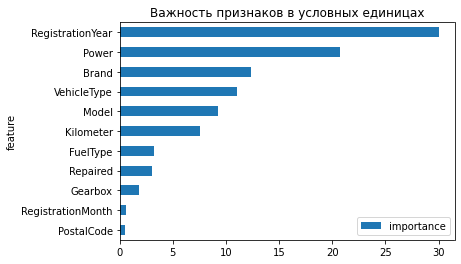

In [110]:
importance.plot(kind='barh', x='feature', title='Важность признаков в условных единицах')

Наша гипотеза о том, что почтовый индекс может влиять на цену не подтвердилась. Она не оказывает практически никакого влияния, точно также как и месяц регистрации. Самым важным признаком является год реистрации, это правда важно, потому что от этого признака зависит, наскоько машина старая.

## Подведение итогов

Мы провели исследование данных, проверили на наличие аномалий и избавились от них. Далее, протестировали несколько моделей, а именно LinearRegression, RandomForestRegressor, lightGBM, CatBoostRegressor. Сравнили результаты, время обучения и скорость предсказания и выбрали оптимальную.

Во время работы было выолнено 7 следующих пунктов:

- Загрузка данных
- Изучение данных
- Подготовка выборок
- Обучение разных моделей
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели
- Подведение итогов

По итогам работы выбрали модель CatBoostRegressor, время обучения составило 90 секунд, предсказание заняло примерно 1 секунду для 125000 значений в тестовой выборке. Значение метрики rmse равно 1683, что означает, что задача успешно выполнена!
